# Las losowy
### Parametry:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**

### Przewidujemy: *level*

In [1]:
import pandas as pd


X = pd.read_json("../../output/bestiary_system_basic.json")

In [2]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   cha     1206 non-null   int64
 1   con     1206 non-null   int64
 2   dex     1206 non-null   int64
 3   int     1206 non-null   int64
 4   str     1206 non-null   int64
 5   wis     1206 non-null   int64
 6   ac      1206 non-null   int64
 7   hp      1206 non-null   int64
 8   level   1206 non-null   int64
dtypes: int64(9)
memory usage: 94.2 KB


In [3]:
X.head()

,cha,con,dex,int,str,wis,ac,hp,level
0,1,5,2,1,7,2,29,215,10
1,1,5,0,-4,9,2,28,220,10
2,-2,6,3,-4,7,3,25,175,8
3,6,5,4,6,7,5,41,315,17
4,1,1,3,-1,-5,1,16,20,1


###### Level

In [4]:
y = X.pop("level")

In [5]:
print(y)

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64


In [6]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [7]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
print(level_count)

    lvl  count
0    -1     34
1     0     27
2     1    127
3     2    121
4     3     95
5     4     82
6     5     76
7     6     72
8     7     77
9     8     68
10    9     63
11   10     58
12   11     40
13   12     41
14   13     36
15   14     33
16   15     31
17   16     25
18   17     21
19   18     21
20   19     18
21   20     24
22   21      8
23   22      1
24   23      4
25   24      2
26   25      1


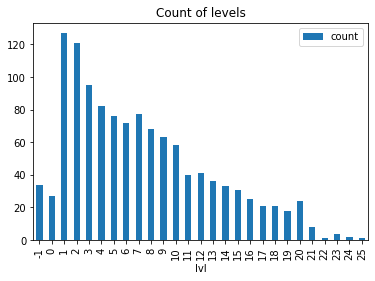

In [8]:
import matplotlib.pyplot as plt

level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Podział na zbiór treningowy i testowy

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0, shuffle=True
)

## Regresja lasem losowym

In [17]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=500, max_depth=2, random_state=0, n_jobs=-1)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, n_estimators=500, n_jobs=-1, random_state=0)

In [30]:
from sklearn.metrics import r2_score

y_pred_train = rf_reg.predict(X_train)
y_pred_test = rf_reg.predict(X_test)

r2 = r2_score(y_train, y_pred_train)
print(f"R2 score: {r2:.2f}")

R2 score: 0.94


R2 jest blisko 1, więc model jest dobrze dostosowany do danych

In [32]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"Mean square error: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

Mean square error: 1.97
RMSE: 1.40


RMSE jest duże, zobaczymy zmianę wyników po tuningu.

In [33]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 1.39
RMSE test: 1.40


Nie ma overfittingu.

## Tuning

In [49]:
from sklearn.metrics import r2_score


def assess_regression_model(model, X_train, X_test, y_train, y_test) -> None:
    # predict for train and test
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    # calculate R2
    r2 = r2_score(y_pred_train, y_train)
    # calculate train and test RMSE
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
    # print train and test RMSE
    print(f"R2: {r2:.2f}")
    print(f"RMSE train: {rmse_train:.2f}")
    print(f"RMSE test: {rmse_test:.2f}")

### Tuning Lasu

In [76]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = [0.1, 0.2, 0.3, 0.4, 0.5]
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

hyper_params = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

print(hyper_params)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [77]:
rf = RandomForestRegressor(random_state=0, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=hyper_params,
    n_iter=100,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=50, max_features=0.1, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=50, max_features=0.1, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=50, max_features=0.1, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=20, max_features=0.5, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=20, max_features=0.5, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=20, max_features=0.5, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=200; to

[CV] END bootstrap=True, max_depth=80, max_features=0.3, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=   0.7s
[CV] END bootstrap=True, max_depth=80, max_features=0.3, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=   0.8s
[CV] END bootstrap=True, max_depth=80, max_features=0.3, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=   0.7s
[CV] END bootstrap=False, max_depth=30, max_features=0.2, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=   0.9s
[CV] END bootstrap=False, max_depth=30, max_features=0.2, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=   0.9s
[CV] END bootstrap=False, max_depth=30, max_features=0.2, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=   0.9s
[CV] END bootstrap=False, max_depth=80, max_features=0.2, min_samples_leaf=1, min_samples_split=10, n_estimators=1400; total time=   0.8s
[CV] END bootstrap=False, max_depth=80, 

[CV] END bootstrap=False, max_depth=80, max_features=0.4, min_samples_leaf=1, min_samples_split=5, n_estimators=1800; total time=   1.1s
[CV] END bootstrap=False, max_depth=80, max_features=0.4, min_samples_leaf=1, min_samples_split=5, n_estimators=1800; total time=   1.1s
[CV] END bootstrap=False, max_depth=80, max_features=0.4, min_samples_leaf=1, min_samples_split=5, n_estimators=1800; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=0.5, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   0.5s
[CV] END bootstrap=False, max_depth=None, max_features=0.4, min_samples_leaf=1, min_samples_split=2, n_estimators=1600; total time=   1.0s
[CV] END bootstrap=False, max_depth=

[CV] END bootstrap=False, max_depth=110, max_features=0.3, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   0.9s
[CV] END bootstrap=False, max_depth=110, max_features=0.3, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   1.0s
[CV] END bootstrap=False, max_depth=110, max_features=0.3, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   0.9s
[CV] END bootstrap=True, max_depth=40, max_features=0.3, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=   0.8s
[CV] END bootstrap=True, max_depth=40, max_features=0.3, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=   0.8s
[CV] END bootstrap=True, max_depth=40, max_features=0.3, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=   0.8s
[CV] END bootstrap=True, max_depth=90, max_features=0.4, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   0.5s
[CV] END bootstrap=True, max_depth=90, m

[CV] END bootstrap=False, max_depth=60, max_features=0.3, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=0.3, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=0.3, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=   0.4s
[CV] END bootstrap=False, max_depth=40, max_features=0.2, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   0.5s
[CV] END bootstrap=False, max_depth=40, max_features=0.2, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   0.5s
[CV] END bootstrap=False, max_depth=40, max_features=0.2, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   0.5s
[CV] END bootstrap=False, max_depth=60, max_features=0.3, min_samples_leaf=4, min_samples_split=10, n_estimators=1400; total time=   0.9s
[CV] END bootstrap=False, max_depth=60, max

{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 0.5,
 'max_depth': None,
 'bootstrap': False}

In [78]:
assess_regression_model(rf_random, X_train, X_test, y_train, y_test)

R2: 1.00
RMSE train: 0.17
RMSE test: 0.51


### Próba zmniejszenia overfittingu
Zwiększam min_sample_leaf, żeby nie było liści z jedną wartością.

In [81]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = [0.1, 0.2, 0.3, 0.4, 0.5]
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [8, 10, 12, 14]
min_samples_leaf = [4, 5, 6, 8]
bootstrap = [True, False]

hyper_params = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

rf = RandomForestRegressor(random_state=0, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=hyper_params,
    n_iter=100,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=80, max_features=0.4, min_samples_leaf=6, min_samples_split=14, n_estimators=1200; total time=   0.6s
[CV] END bootstrap=False, max_depth=80, max_features=0.4, min_samples_leaf=6, min_samples_split=14, n_estimators=1200; total time=   0.6s
[CV] END bootstrap=False, max_depth=80, max_features=0.4, min_samples_leaf=6, min_samples_split=14, n_estimators=1200; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, max_features=0.1, min_samples_leaf=5, min_samples_split=12, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=20, max_features=0.1, min_samples_leaf=5, min_samples_split=12, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=20, max_features=0.1, min_samples_leaf=5, min_samples_split=12, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=70, max_features=0.4, min_samples_leaf=6, min_samples_split=14, n_estimators=200

[CV] END bootstrap=True, max_depth=110, max_features=0.5, min_samples_leaf=4, min_samples_split=12, n_estimators=1400; total time=   0.9s
[CV] END bootstrap=True, max_depth=110, max_features=0.5, min_samples_leaf=4, min_samples_split=12, n_estimators=1400; total time=   0.9s
[CV] END bootstrap=True, max_depth=110, max_features=0.5, min_samples_leaf=4, min_samples_split=12, n_estimators=1400; total time=   0.9s
[CV] END bootstrap=False, max_depth=None, max_features=0.4, min_samples_leaf=5, min_samples_split=12, n_estimators=600; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, max_features=0.4, min_samples_leaf=5, min_samples_split=12, n_estimators=600; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, max_features=0.4, min_samples_leaf=5, min_samples_split=12, n_estimators=600; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, max_features=0.1, min_samples_leaf=4, min_samples_split=14, n_estimators=400; total time=   0.2s
[CV] END bootstrap=False, max_

[CV] END bootstrap=False, max_depth=10, max_features=0.4, min_samples_leaf=8, min_samples_split=14, n_estimators=800; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, max_features=0.4, min_samples_leaf=8, min_samples_split=14, n_estimators=800; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, max_features=0.4, min_samples_leaf=8, min_samples_split=14, n_estimators=800; total time=   0.5s
[CV] END bootstrap=False, max_depth=20, max_features=0.4, min_samples_leaf=8, min_samples_split=10, n_estimators=1400; total time=   0.8s
[CV] END bootstrap=False, max_depth=20, max_features=0.4, min_samples_leaf=8, min_samples_split=10, n_estimators=1400; total time=   0.8s
[CV] END bootstrap=False, max_depth=20, max_features=0.4, min_samples_leaf=8, min_samples_split=10, n_estimators=1400; total time=   0.8s
[CV] END bootstrap=True, max_depth=40, max_features=0.2, min_samples_leaf=5, min_samples_split=10, n_estimators=600; total time=   0.4s
[CV] END bootstrap=True, max_depth=40, 

[CV] END bootstrap=True, max_depth=10, max_features=0.2, min_samples_leaf=4, min_samples_split=8, n_estimators=400; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=0.2, min_samples_leaf=4, min_samples_split=8, n_estimators=400; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=0.2, min_samples_leaf=4, min_samples_split=8, n_estimators=400; total time=   0.2s
[CV] END bootstrap=True, max_depth=60, max_features=0.2, min_samples_leaf=8, min_samples_split=10, n_estimators=1600; total time=   1.0s
[CV] END bootstrap=True, max_depth=60, max_features=0.2, min_samples_leaf=8, min_samples_split=10, n_estimators=1600; total time=   1.0s
[CV] END bootstrap=True, max_depth=60, max_features=0.2, min_samples_leaf=8, min_samples_split=10, n_estimators=1600; total time=   0.9s
[CV] END bootstrap=True, max_depth=20, max_features=0.2, min_samples_leaf=4, min_samples_split=14, n_estimators=1200; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, max_feat

[CV] END bootstrap=True, max_depth=40, max_features=0.2, min_samples_leaf=8, min_samples_split=10, n_estimators=1200; total time=   0.7s
[CV] END bootstrap=True, max_depth=40, max_features=0.2, min_samples_leaf=8, min_samples_split=10, n_estimators=1200; total time=   0.7s
[CV] END bootstrap=True, max_depth=40, max_features=0.2, min_samples_leaf=8, min_samples_split=10, n_estimators=1200; total time=   0.7s
[CV] END bootstrap=False, max_depth=80, max_features=0.2, min_samples_leaf=5, min_samples_split=12, n_estimators=600; total time=   0.4s
[CV] END bootstrap=False, max_depth=80, max_features=0.2, min_samples_leaf=5, min_samples_split=12, n_estimators=600; total time=   0.4s
[CV] END bootstrap=False, max_depth=80, max_features=0.2, min_samples_leaf=5, min_samples_split=12, n_estimators=600; total time=   0.4s
[CV] END bootstrap=True, max_depth=70, max_features=0.3, min_samples_leaf=8, min_samples_split=10, n_estimators=1800; total time=   1.3s
[CV] END bootstrap=True, max_depth=70, ma

{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 0.5,
 'max_depth': 10,
 'bootstrap': False}

In [82]:
assess_regression_model(rf_random, X_train, X_test, y_train, y_test)

R2: 1.00
RMSE train: 0.32
RMSE test: 0.53


Overfitting jest mniejszy.

### Sprawdzenie wyników po zaokrągleniu

In [126]:
from copy import deepcopy

predict = rf_random.predict(X_test)
round_predict = np.round(predict)

In [127]:
def check_predictions(y, y_pred):
    print(f"Mean square error: {mean_squared_error(y, y_pred):.2f}")
    print(f"RMSE: {mean_squared_error(y, y_pred, squared=False):.2f}")
    print(f"Mean absolute error = {mean_absolute_error(y, y_pred):.2f}")
    print(f"Median absolute error = {median_absolute_error(y, y_pred):.2f}")
    print()

In [128]:
print("Normal:")
check_predictions(y_test, predict)

print("Round:")
check_predictions(y_test, round_predict)

Normal:
Mean square error: 0.28
RMSE: 0.53
Mean absolute error = 0.34
Median absolute error = 0.19

Round:
Mean square error: 0.28
RMSE: 0.53
Mean absolute error = 0.24
Median absolute error = 0.00



### Macierz sąsiedztwa

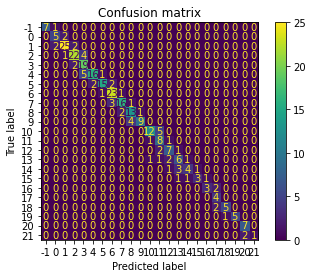

In [132]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, round_predict)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=np.unique(round_predict).astype("int")
)

disp.plot()
plt.title("Confusion matrix")
plt.show()